In [11]:
%load_ext autoreload
%autoreload 2

from hyperopt import fmin, hp, tpe, STATUS_OK, Trials, space_eval
from sklearn.base import clone
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import warnings
from pathlib import Path

from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibrationDisplay
import seaborn as sns

# from mfllowcli import _log_mlflow
from SE.ml.umodel import UnifiedModelAPI

from sklearn.metrics import average_precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle
# from metrics import recall_at, recall_at_pct

import mlflow
from model import get_model
# from propmatch.mlflowcli import log_mlflow
import json
# from utils import get_perf_metrics, ModelPerf
from functools import partial
from sklearn.metrics import make_scorer
import pylab as plt

from mlflow_utils import mlflow_log_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from model import get_model
from utils import reduce_memory
from metrics import (
    precision_at_f, precision_at_85,
    recall_at_85, recall_at_f, METRICS
)

In [3]:
from mlflow_utils import mlflow_log_model

## Set Default AWS Profile

In [4]:
import boto3

boto3.session.Session().available_profiles

['se-stage',
 'se-prod',
 'zgdatalake',
 'zgdatalake-staging',
 'sedatalakeprodreadonly',
 'sedatalakeprodreadwrite',
 'sedatalakeadmin',
 'sedatalakestagingreadonly',
 'sedatalakestagingreadwrite',
 'sedatalakeadmin-stage',
 'default']

In [5]:
# boto3.setup_default_session(profile_name='sedatalakestagingreadwrite')
boto3.setup_default_session(profile_name='sedatalakeprodreadwrite')

## Load Data

In [6]:
trxn_ids_train = pd.read_parquet('./data/train/trxn_id_train.parquet')

In [7]:
# data
X = pd.read_parquet('./data/train/X.parquet')
y = pd.read_parquet('./data/train/y.parquet').iloc[:, 0]

In [8]:
X_train = pd.read_parquet('./data/train/X_resampled_10.parquet')
y_train = pd.read_parquet('./data/train/y_resampled_10.parquet').iloc[:, 0]

In [9]:
X_val = pd.read_parquet('./data/train/Xval.parquet')
y_val = pd.read_parquet('./data/train/yval.parquet').iloc[:, 0]

In [10]:
w_train = np.where(y_train, 50, 1)

## Model

In [18]:
params = {
#     'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [19]:
MODEL = get_model(LGBMClassifier).set_params(**params)

In [20]:
MODEL

Pipeline(steps=[('model',
                 LGBMClassifier(min_child_samples=51, min_child_weight=1e-05,
                                num_leaves=21, reg_alpha=0.1, reg_lambda=5,
                                subsample=0.4301443471481221))])

## HP Optimisation

In [12]:
scoring={'average_precision': make_scorer(average_precision_score, average='weighted'),
         'roc_auc': make_scorer(roc_auc_score, average='weighted'),
         'precisin_at_95':make_scorer(precision_at_f, needs_proba=True, greater_is_better=True)
        }

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [41]:

space ={
    'model__boosting_type': hp.choice('model__boosting_type', ['gbdt', 'dart', 'goss']),
    'model__class_weight': hp.choice('model__class_weight', [None, 'balanced']),
    'model__learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
     'model__subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
        'model__feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'model__bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'model__min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'model__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'model__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'model__verbose': -1,
        #the LGBM parameters docs list various aliases, and the LGBM implementation seems to complain about
        #the following not being used due to other params, so trying to silence the complaints by setting to None
        'model__subsample': None, #overridden by bagging_fraction
        'model__reg_alpha': None, #overridden by lambda_l1
        'model__reg_lambda': None, #overridden by lambda_l2
        'model__min_sum_hessian_in_leaf': None, #overrides min_child_weight
        'model__min_child_samples': None, #overridden by min_data_in_leaf
        'model__colsample_bytree': None, #overridden by feature_fraction
#        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
        'model__min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
#     'model__bagging_fraction': hp.uniform('model__bagging_fraction', 0.5, 1), 
#     'model__subsample_for_bin': hp.quniform('model__subsample_for_bin', 20000, 300000, 20000),
#     'model__max_depth': hp.uniformint('model__max_depth', 1, 30),
#     'model__max_bin': hp.uniformint('model__max_bin', 10, 1000),
#     'model__subsample': hp.uniform('model__subsample', 0.1, 1),
#     'model__min_child_samples': hp.quniform('model__min_child_samples', 20, 500, 5),
#     'model__min_child_weight': hp.uniform('model__min_child_weight', 0.001, 500),
#     'model__colsample_bytree': hp.uniform('model__colsample_bytree', 0.3, 0.9),
#     'model__min_gain_to_split': hp.uniformint('model__min_gain_to_split', 0,15),
#     'model__min_data_in_leaf': hp.uniformint('model__min_data_in_leaf', 5,300),
#     'preprocessor__ut__sigma': hp.uniform('preprocessor__ut__sigma', 0.05,0.6)
    
} 

In [25]:
trials = Trials()

In [44]:
def objective(params):
    # Convert some hyperparameters to integers
    for col in 'model__min_data_in_leaf', 'model__max_depth': #'model__min_child_samples':
        if col in params:
            params[col] = int(params[col])
    for col in ('model__subsample_for_bin', ):
        if col in params:
            params[col] = int(float(params[col]))
    
    # model__estimator__random_state=2022 < for calibration
    model = clone(MODEL).set_params(**params, ) 
    metrics = cross_validate(model, X_train, y_train, cv=skf, return_train_score=False,
               scoring=scoring['roc_auc'])
    
    avg_metrics = pd.DataFrame(metrics).mean()
    metric = 'test_score'
    return {'loss': -1* avg_metrics[metric],
            'status':STATUS_OK, 'metrics':avg_metrics.to_dict()}

In [45]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=35, trials=trials, 
            verbose=1, rstate=np.random.default_rng(42))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [13:50<00:00, 23.74s/trial, best loss: -0.9991727602952027]


In [47]:
best_params = space_eval(space, best)
best_params

{'model__bagging_fraction': 0.6365332955584441,
 'model__boosting_type': 'goss',
 'model__class_weight': None,
 'model__colsample_bytree': None,
 'model__feature_fraction': 0.8672133567704401,
 'model__lambda_l1': 0,
 'model__lambda_l2': 0,
 'model__learning_rate': 0.19766773915494987,
 'model__min_child_samples': None,
 'model__min_child_weight': 2.14037457105386e-06,
 'model__min_data_in_leaf': 1.0,
 'model__min_sum_hessian_in_leaf': None,
 'model__reg_alpha': None,
 'model__reg_lambda': None,
 'model__subsample': None,
 'model__subsample_for_bin': 180000.0,
 'model__verbose': -1}

In [52]:
for col in 'model__min_data_in_leaf', 'model__max_depth': #'model__min_child_samples':
    if col in best_params:
        best_params[col] = int(best_params[col])
for col in ('model__subsample_for_bin', ):
    if col in best_params:
        best_params[col] = int(float(best_params[col]))

## Performance on Validation

In [53]:
best_model = MODEL.set_params(**best_params, model__random_state=2024)
best_model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 LGBMClassifier(bagging_fraction=0.6365332955584441,
                                boosting_type='goss', colsample_bytree=None,
                                feature_fraction=0.8672133567704401,
                                lambda_l1=0, lambda_l2=0,
                                learning_rate=0.19766773915494987,
                                min_child_samples=None,
                                min_child_weight=2.14037457105386e-06,
                                min_data_in_leaf=1,
                                min_sum_hessian_in_leaf=None, num_leaves=21,
                                random_state=2024, reg_alpha=None,
                                reg_lambda=None, subsample=None,
                                subsample_for_bin=180000, verbose=-1))])

In [54]:
metaflow_config = dict(
    tracking_uri='https://mlflow.production.streeteasy.cloud',
    experiment_name='expert_transaction_matching',
    model_name='expert_transaction_matching',
    tags=dict(target='matching')
)

In [59]:
metaflow_config['run_name'] = f'binary_lbgm_data_resampled_10_hp6'
mlflow_log_model(
    best_model,
    X_train,
    y_train,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':6},
    validation=(X_val, y_val, METRICS)
)

2024/03/28 18:26:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/28 18:26:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/03/28 18:26:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/28 18:26:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/28 18:26:34 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('model', LGBMClassifier(bagging_fraction=0.6365332955584441, boosting_type='goss',
               colsample_bytree=None, feature_fraction=0.8672133567704401,
               lambda_l1=0, lambda_l2=0, learning_rate=0.19766773915494987,
               min_child_samples=None, min_child_weight=2.14037457105386e-06,
               min_data_in_leaf=1, min_sum_hessian

Pipeline(steps=[('model',
                 LGBMClassifier(bagging_fraction=0.6365332955584441,
                                boosting_type='goss', colsample_bytree=None,
                                feature_fraction=0.8672133567704401,
                                lambda_l1=0, lambda_l2=0,
                                learning_rate=0.19766773915494987,
                                min_child_samples=None,
                                min_child_weight=2.14037457105386e-06,
                                min_data_in_leaf=1,
                                min_sum_hessian_in_leaf=None, num_leaves=21,
                                random_state=2024, reg_alpha=None,
                                reg_lambda=None, subsample=None,
                                subsample_for_bin=180000, verbose=-1))])

## Add Calibration

In [74]:
y_proba = best_model.predict_proba(X)[:, 1]

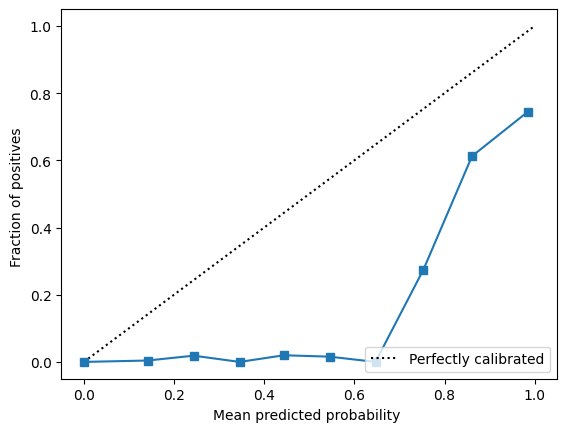

In [75]:
prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()
plt.show()

In [76]:
# ?CalibratedClassifierCV

In [146]:
from sklearn.calibration import CalibratedClassifierCV
cparams = { 'method': 'sigmoid', #'isotonic', #'sigmoid',
            'ensemble':True,
            'cv': 10}

In [147]:
calibrated = CalibratedClassifierCV(best_model, **cparams)

# estimator = MODEL.steps[-1][-1]
# calibrated.steps[-1] = ('model', CalibratedClassifierCV(estimator, **cparams))

In [148]:
calibrated.fit(X_train, y_train)

y_pred_c = calibrated.predict_proba(X)[:, 1]
y_c = calibrated.predict(X)

2024/03/28 19:18:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c726159d33c1496899d816c36fc3bd90', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/28 19:18:56 WARNING mlflow.utils: Truncated the value of the key `estimator__steps`. Truncated value: `[('model', LGBMClassifier(bagging_fraction=0.6365332955584441, boosting_type='goss',
               colsample_bytree=None, feature_fraction=0.8672133567704401,
               lambda_l1=0, lambda_l2=0, learning_rate=0.19766773915494987,
               min_child_samples=None, min_child_weight=2.14037457105386e-06,
               min_data_in_leaf=1, min_sum_hessian_in_leaf=None, num_leaves=21,
               random_state=2024, reg_alpha=None, reg_lambda=None,
               subsample=None, subsa...`
2024/03/28 19:18:56 WARNING mlflow.utils: Truncated the value of the key `estimator__model`. Truncated value: `LGBMClassifier(

In [149]:
prob_true, prob_pred = calibration_curve(y, y_pred_c, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_c)
disp.plot()

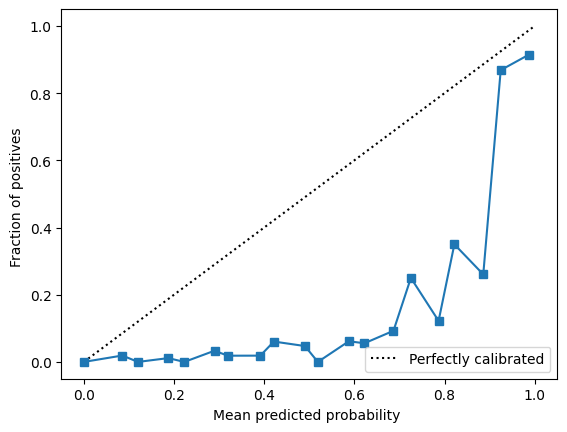

In [150]:
plt.show()

## Curves

In [141]:
prec, recall, step = precision_recall_curve(y, y_pred_c, pos_label=1)

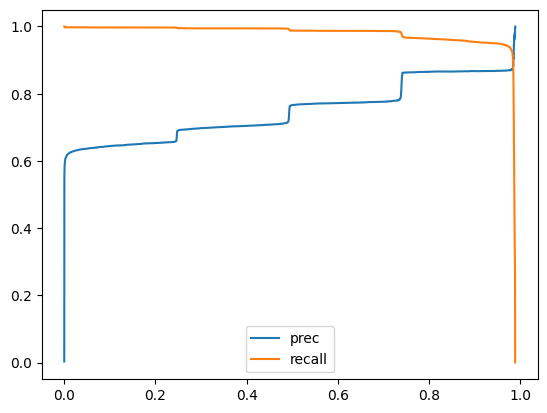

In [142]:
curve_df = pd.DataFrame({'prec':prec[:-1], 'recall':recall[:-1]}, index=step)
curve_df.plot()
plt.show();

In [145]:
curve_df[curve_df.index > 0.2].head(3)

,prec,recall
0.202884,0.653311,0.996843
0.203865,0.653434,0.996843
0.204647,0.653557,0.996843


In [90]:
curve_df[curve_df.index > 0.99].head(3)

,prec,recall
0.990014,0.979525,0.343284
0.990035,0.979491,0.342710
0.990057,0.979441,0.341848


In [120]:
# X_val.dtypes

## Store

In [92]:
metaflow_config['run_name'] = 'binary_lbgm_rsmpl01_hp_calibrated'
mlflow_log_model(
    calibrated,
    X_train,
    y_train,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':7},
    validation=(X_val, y_val, METRICS),
)

2024/03/28 18:37:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/28 18:37:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/03/28 18:37:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/28 18:37:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/28 18:37:51 WARNING mlflow.utils: Truncated the value of the key `estimator__steps`. Truncated value: `[('model', LGBMClassifier(bagging_fraction=0.6365332955584441, boosting_type='goss',
               colsample_bytree=None, feature_fraction=0.8672133567704401,
               lambda_l1=0, lambda_l2=0, learning_rate=0.19766773915494987,
               min_child_samples=None, min_child_weight=2.14037457105386e-06,
               min_data_in_leaf=1, min_

CalibratedClassifierCV(cv=4,
                       estimator=Pipeline(steps=[('model',
                                                  LGBMClassifier(bagging_fraction=0.6365332955584441,
                                                                 boosting_type='goss',
                                                                 colsample_bytree=None,
                                                                 feature_fraction=0.8672133567704401,
                                                                 lambda_l1=0,
                                                                 lambda_l2=0,
                                                                 learning_rate=0.19766773915494987,
                                                                 min_child_samples=None,
                                                                 min_child_weight=2.14037457105386e-06,
                                                                 min_data_in_leaf=1,
                                                                 min_sum_hessian_in_leaf=None,
                                                                 num_leaves=21,
                                                                 random_state=2024,
                                                                 reg_alpha=None,
                                                                 reg_lambda=None,
                                                                 subsample=None,
                                                                 subsample_for_bin=180000,
                                                                 verbose=-1))]),
                       method='isotonic')

In [131]:
X_train_2 = X_train.copy()
bool_cols = [c for c in X_train_2.columns if c.startswith('same')]

X_train_2[bool_cols] = X_train_2[bool_cols].astype(bool)

In [132]:
X_train_2 = reduce_memory(X_train_2)

Mem. usage decreased to 43.07 Mb (58.8%% reduction)


In [127]:
X_val[bool_cols] = X_val[bool_cols].astype(bool)

In [128]:
X_val = reduce_memory(X_val)

Mem. usage decreased to  4.31 Mb (0.0%% reduction)


In [134]:
metaflow_config['run_name'] = 'binary_lbgm_rsmpl01_hp_boolean'
mlflow_log_model(
    calibrated,
    X_train_2,
    y_train,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':7},
    validation=(X_val, y_val, METRICS),
)

2024/03/28 19:00:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/28 19:00:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/03/28 19:00:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/28 19:00:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/28 19:00:50 WARNING mlflow.utils: Truncated the value of the key `estimator__steps`. Truncated value: `[('model', LGBMClassifier(bagging_fraction=0.6365332955584441, boosting_type='goss',
               colsample_bytree=None, feature_fraction=0.8672133567704401,
               lambda_l1=0, lambda_l2=0, learning_rate=0.19766773915494987,
               min_child_samples=None, min_child_weight=2.14037457105386e-06,
               min_data_in_leaf=1, min_

CalibratedClassifierCV(cv=4,
                       estimator=Pipeline(steps=[('model',
                                                  LGBMClassifier(bagging_fraction=0.6365332955584441,
                                                                 boosting_type='goss',
                                                                 colsample_bytree=None,
                                                                 feature_fraction=0.8672133567704401,
                                                                 lambda_l1=0,
                                                                 lambda_l2=0,
                                                                 learning_rate=0.19766773915494987,
                                                                 min_child_samples=None,
                                                                 min_child_weight=2.14037457105386e-06,
                                                                 min_data_in_leaf=1,
                                                                 min_sum_hessian_in_leaf=None,
                                                                 num_leaves=21,
                                                                 random_state=2024,
                                                                 reg_alpha=None,
                                                                 reg_lambda=None,
                                                                 subsample=None,
                                                                 subsample_for_bin=180000,
                                                                 verbose=-1))]),
                       method='isotonic')